In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
from torchvision.models import vgg19
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
from PIL import Image

VGG also has a batch normalized version. The paper didn't specify if batch norm was used

In [2]:
torch.cuda.set_device(0)

vgg = vgg19(True).eval().cuda()

In [3]:
preprocess = transforms.Compose([transforms.Resize(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

im_a = Image.open("./images/dog1.jpg")
im_a_tens = V(preprocess(im_a).unsqueeze(0)).cuda()
out = vgg(im_a_tens)
print('Prediction for cat.jpg is: %s'%(np.argmax(out.cpu().detach().numpy())))

im_b = Image.open("./images/dog2.jpg")
im_b_tens = V(preprocess(im_b).unsqueeze(0)).cuda()
out = vgg(im_b_tens)
print('Prediction for dog.jpg is: %s'%(np.argmax(out.cpu().detach().numpy())))

Prediction for cat.jpg is: 207
Prediction for dog.jpg is: 207


#### VGG is verified making correct predictions

## Now let's extract the features pyramid (section 3.1)
#### Check the VGG architecture

In [4]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

#### We want the outputs of the 5 ReLUs just before max pooling

In [5]:
feature_pyramid = []
def extract_feature(self, input, output):
    feature_pyramid.append(output)

layer_inds = [3, 8, 17, 26, 35]

for layer_ind in layer_inds:
    vgg.features[layer_ind].register_forward_hook(extract_feature)

In [6]:
feature_pyramid = []
vgg(im_a_tens)
vgg(im_b_tens)
feat_a = feature_pyramid[:5]
feat_b = feature_pyramid[5:]

and those are the relu1_1 ~ relu5_1 outputs of image A and B

### Generate common appearance (3.3)
[Adaptive Instance Normalization [Huang et al. 2017]][1] is used for real time generation of common appearance. For the purpose of Neural Best Buddies, spatial mean and standard deviation are taken over both images, and the technique is only applied locally

[1]: https://arxiv.org/abs/1703.06868

In [15]:
# TODO: need mean and standard deviations across each channel instead of everything

class CommonAppearance(torch.nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
        self.train(False)
        
    def forward(self, P, Q):
        P = P.squeeze()
        Q = Q.squeeze()
        mu_a = P.mean(2).mean(1)
        mu_b = Q.mean(2).mean(1)
        mu_m = (mu_a + mu_b) / 2
        sig_a = P.std(2).std(1)
        sig_b = Q.std(2).std(1)
        sig_m = (sig_a + sig_b) / 2
        P_common = ((P.permute(1,2,0) - mu_a) / sig_a * sig_m + mu_m).permute(2,0,1)
        Q_common = ((Q.permute(1,2,0) - mu_b) / sig_b * sig_m + mu_m).permute(2,0,1)        
        return P_common, Q_common

commonAppearance = CommonAppearance()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [16]:
im_a_common, im_b_common = commonAppearance(im_a_tens, im_b_tens)

F.to_pil_image(im_a_common.cpu())

NameError: name 'commonAppearance' is not defined

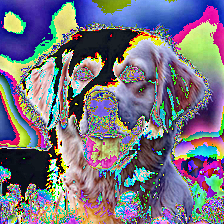

In [9]:
F.to_pil_image(im_b_common.cpu())

### Now we calculate the normalized cross-correlation of neuron neighborhoods (3.3) and extract Neural Best Buddies from them (3.2).

In [10]:
class NeuralBestBuddies(torch.nn.Module):
    def __init__(self):
        super(NeuralBestBuddies, self).__init__()
        self.train(False)
        
    def _get_neighborhood(self, P, i, j, neigh_rad):
        # 2
        P = P.permute(1, 2, 0)
        P_padded = torch.zeros((P.size()[0] + 2 * neigh_rad, P.size()[1] + 2 * neigh_rad, P.size()[2]))
        P_padded[neigh_rad: -neigh_rad, neigh_rad: -neigh_rad] = P
        return P_padded[i: i + 2 * neigh_rad + 1, j: j + 2 * neigh_rad + 1].permute(2, 0, 1)
    
    def forward(self, Ps, Qs, neigh_rad, gamma=0.05):
        """
        args:
            P: 4D tensor of features in NCHW format
            Q: 4D tensor of features in NCHW format
            neigh_rad: int representing amount of surrounding neighbors to include in cross correlation.
                       so neigh_rad of 1 takes cross correlation of 3x3 patches of neurons
            gamma: (optional) activation threshold
        output:
            NBB pairs
        """
        
        height = Ps.size()[2]
        width = Ps.size()[3]
        n_channels = Ps.size()[1]
        
        best_buddies = []
        
        for P, Q in zip(Ps, Qs):
            #2
            P_L2 = P.clone().permute(1,2,0).norm(2, 2)
            Q_L2 = Q.clone().permute(1,2,0).norm(2, 2)
            
            P_over_L2 = P.div(P_L2)
            Q_over_L2 = Q.div(Q_L2)
                                    
            P_nearest = []
            Q_nearest = []
            for i in range(0, height):
                for j in range(0, width):
                    p_neigh = self._get_neighborhood(P_over_L2, i, j, neigh_rad)
                    # 1
                    conv = torch.nn.Conv2d(n_channels, 1, neigh_rad * 2 + 1, padding=neigh_rad).cuda()
                    conv.train(False)
                    conv.weight.data.copy_(p_neigh.unsqueeze(0))
                    p_cross_corrs = conv(Q_over_L2.unsqueeze(0)).squeeze().view(-1)
                    # 4
                    P_nearest.append(p_cross_corrs.argmax())
                    
                    q_neigh = self._get_neighborhood(Q_over_L2, i, j, neigh_rad)
                    conv = torch.nn.Conv2d(n_channels, 1, neigh_rad * 2 + 1, padding=neigh_rad).cuda()
                    conv.train(False)
                    conv.weight.data.copy_(q_neigh.unsqueeze(0))
                    q_cross_corrs = conv(P_over_L2.unsqueeze(0)).squeeze().view(-1)
                    Q_nearest.append(q_cross_corrs.argmax())
            
            # 5
            P_L2_min = P_L2.min()
            P_L2_max = P_L2.max()
            P_normalized = (P_L2.view(-1) - P_L2_min) / (P_L2_max - P_L2_min)
            
            Q_L2_min = Q_L2.min()
            Q_L2_max = Q_L2.max()
            Q_normalized = (Q_L2.view(-1) - Q_L2_min) / (Q_L2_max - Q_L2_min)
            
            for i in range(len(P_nearest)):
                if(i == Q_nearest[P_nearest[i]] and P_normalized[i] > gamma and Q_normalized[P_nearest[i]] > gamma):
                    best_buddies.append((i, int(P_nearest[i])))
                    
        return best_buddies

Some of my thought process:
1. Instead of using a double for-loop to compute cross correlations, we use pytorch convolution with each neuron neighborhoob to do it much faster since cross correlations are really just a special case of convolutions in ML.

2. Since we are using convolution to compute cross correlations, we can't compute the L2 norm of the neurons we are convoluting over on the fly. So instead, the L2 norm of each neuron neighborhood is calculated ahead of time.

3. To access a vector of channels at a specific position, we use permute to convert the tensor from CHW (channel x height x width). Then we must convert it back to CHW - the required format for pytorch convolution.  

4. Because we just convolved over Q using p_neigh, we now have a 2D tensor:
      
\begin{bmatrix}
p_{i,j}	\otimes q_{1,1} & p_{i,j} \otimes q_{1,2} & \dots & p_{i,j} \otimes q_{1,-2} & p_{i,j} \otimes q_{1,-1}\\
p_{i,j}	\otimes q_{2,1} & p_{i,j} \otimes q_{2,2} & \dots & p_{i,j} \otimes q_{2,-2} & p_{i,j} \otimes q_{2,-1}\\
\vdots & \vdots & & \vdots & \vdots \\
p_{i,j}	\otimes q_{-2,1} & p_{i,j} \otimes q_{-2,2} & \dots & p_{i,j} \otimes q_{-2,-2} & p_{i,j} \otimes q_{-2,-1}\\
p_{i,j}	\otimes q_{-1,1} & p_{i,j} \otimes q_{-1,2} & \dots & p_{i,j} \otimes q_{-1,-2} & p_{i,j} \otimes q_{-1,-1}\\
\end{bmatrix}

   where $\otimes$ denotes cross correlation without the denominator term, and $p_{x,y}$ denotes the neighborhood tensor of the neuron at position $(x,y)$. A negative coordinate indicates that the position of the neuron is counted from the end.
   
   In this 2D tensor, the $q$ with the highest cross correlation is the nearest neighbor of $p_{i,j}$. This is added to the list *P_nearest*, which contains the nearest neighbor of each neuron neighborhood in *P*. The same is done for each neighborhood of neurons in Q.
   
5. Finally, we gather the NBBs - pairs of neuron that are nearest neighbors of each other. We also only keep the pairs where each neuron's normalized activation is above a certain threshold.

In [11]:
nbb = NeuralBestBuddies()

lambda_5 = nbb(feat_a[4], feat_b[4], 1)
print(*lambda_5)

(1, 3) (2, 4) (11, 9) (12, 10) (23, 35) (25, 23) (26, 24) (30, 44) (38, 51) (40, 53) (44, 45) (45, 46) (46, 47) (51, 49) (52, 65) (53, 66) (54, 67) (60, 60) (61, 61) (62, 62) (67, 80) (68, 81) (74, 74) (75, 75) (77, 76) (78, 77) (79, 78) (81, 94) (82, 95) (92, 91) (93, 92) (95, 108) (96, 109) (99, 99) (100, 100) (107, 106) (114, 114) (115, 115) (116, 116) (120, 118) (121, 119) (129, 129) (130, 130) (131, 131) (134, 132) (135, 133) (136, 134) (137, 136) (138, 137) (139, 55) (145, 145)


#### We now have a set of neural best buddies extracted from the deepest features of the images. I plot them on top of the images to get a rough sense of which parts of the images were detected to have high correspondence. 

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import colors as mcolors
from random import shuffle

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
shuffle(colors)

def plot_with_grid(subplt, img, n_cells, neigh_rad, nbbs, a_or_b, my_dpi=60):
    ax=plt.subplot(*subplt)
    grid_width = im_a.size[0] / n_cells
    loc = plticker.MultipleLocator(base=grid_width)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='major', axis='both', linestyle='-', color='lightgrey')
    ax.imshow(img)
    nbb_index = 0 if a_or_b == 'a' else 1
    for index, coords in enumerate(nbbs):
        j=grid_width/2+(coords[nbb_index]//(n_cells))*grid_width
        i=grid_width/2+(coords[nbb_index]%(n_cells))*grid_width
        ax.add_artist(plt.Circle((i, j), 3, color=colors[index], alpha=0.9))
    
plot_with_grid((1,2,1), im_a, feat_a[4].size()[2], 1, lambda_5, 'a')
plot_with_grid((1,2,2), im_b, feat_a[4].size()[2], 1, lambda_5, 'b')

#### Not bad. These NBBs still need to be percolated through the finer feature layers to yield the precise location of NBBs, but the algorithms seem to be identifying similar features.

### Now we use the NBBs of this layer to determine the areas to search for NBBs in the next layer

In [13]:
class RefineSearchWindow(torch.nn.Module):
    def __init__(self):
        super(RefineSearchWindow, self).__init__()
        self.train(False)
        
    def forward(self, P, Q, prev_nbbs, row_size, rec_rad):
        P = P[0].permute(1,2,0)
        Q = Q[0].permute(1,2,0)

        new_Ps = []
        new_Qs = []
        P_coords = []
        Q_coords = []
        for p_coord, q_coord in prev_nbbs:
            p_center = (p_coord // row_size, p_coord % row_size)
            q_center = (q_coord // row_size, q_coord % row_size)
            p_x1 = max(int(2 * p_center[0] - rec_rad / 2), 0)
            p_x2 = min(int(2 * p_center[0] + rec_rad / 2), P.size()[1])
            p_y1 = max(int(2 * p_center[1] - rec_rad / 2), 0)
            p_y2 = min(int(2 * p_center[1] + rec_rad / 2), P.size()[0])
            q_x1 = max(int(2 * q_center[0] - rec_rad / 2), 0)
            q_x2 = min(int(2 * q_center[0] + rec_rad / 2), Q.size()[1])
            q_y1 = max(int(2 * q_center[1] - rec_rad / 2), 0)
            q_y2 = min(int(2 * q_center[1] + rec_rad / 2), Q.size()[0])
            new_Ps.append(P[p_x1: p_x2, p_y1: p_y2])
            new_Qs.append(Q[q_x1: q_x2, q_y1: q_y2])
            P_coords.append((p_x1, p_y1))
            Q_coords.append((q_x1, q_y1))
        return (new_Ps, new_Qs, P_coords, Q_coords)

In [14]:
refineSearchWindow = RefineSearchWindow()
Ps_4, Qs_4, P_coords, Q_coords = refineSearchWindow(feat_a[3], feat_b[3], lambda_5, feat_a[4].size()[3], 6)